(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [86]:
# Load project package
@load_pkg BayesFitUtils

# Import project package
import BayesFitUtils

# Import package to handle DataFrames
import DataFrames as DF
import CSV
import Tables

# Import package to load chains
import JLD2

# Import package to handle MCMC chain objects
import MCMCChains

# Import basic statistical functions
import StatsBase
import Distributions

# Import library to list files
import Glob

# Load CairoMakie for plotting
using CairoMakie
import ColorSchemes
import Makie
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
BayesFitUtils.viz.pboc_makie!()

# Fitness inference exploratory data analysis for Kinsler et al., 2020

Having processed the data from Kinsler et al., 2020 with the proposed Bayesian
inference pipeline, we will perform an exploratory data analysis of the outcome.

## Loading data and inferences

Let's begin by loading the raw data.

In [87]:
data = CSV.read(
    "$(git_root())/data/kinsler_2020/tidy_counts_no_anc.csv", DF.DataFrame
)

first(data, 3)

Row,additional_muts,barcode,class,gene,ploidy,type,name,count,rep,timepoint,time,env,neutral,category,count_sum,freq
,String,Int64,String31,String31,String15,String31,String15,Int64,String3,String3,Int64,String15,Bool,String7,Int64,Float64
1,TIP1-upstream_point_variant; YKR012C-upstream_indel_variant; APM2-upstream_indel_variant; RPL11B-upstream_indel_variant; YIL161W-upstream_indel_variant; YIL169C-frameshift_variant,53,Diploid,Diploid,Diploid,Diploid,1.4%-T0,22,R1,T0,0,1.4%,false,glucose,29770,0.000738999
2,"SEH1-missense_variant; ZIP1-missense_variant; MIM1,tS-upstream_indel_variant; YFL019C,SUF9-upstream_indel_variant",151,PKA,IRA1,Haploid,stop_gained,1.4%-T0,629,R1,T0,0,1.4%,false,glucose,29770,0.0211287
3,NotSequenced,262,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.4%-T0,118,R1,T0,0,1.4%,false,glucose,29770,0.00396372


Next, let's list the `.jld2` files containing the MCMC chains.

In [88]:
# List files
chn_files = Glob.glob(
    "$(git_root())/code/processing/mcmc_kinsler_fitness/output/"[2:end] *
    "kinsler*jld2",
    "/"
)

println("# files = $(length(chn_files))")

# files = 51


Let us begin exploring one of these files to later generalize the analysis
pipeline. Each `.jld2` file contains two objects:
- `chain`: The `MCMCChains.Chain` object with all the samples.
- `group`: An array listing the identity of each of the mutants in the order
  they follow in the chain.

Let's load the chain and rename the variables to the barcode names.

In [89]:
# Load chain and group object form .jld2 file
chn, group = values(JLD2.load(chn_files[1]))

# Search for variable names
s_names = MCMCChains.namesingroup(chn, "s̲⁽ᵐ⁾")
# Search for variable names
σ_names = MCMCChains.namesingroup(chn, "σ̲⁽ᵐ⁾")

# Rename variables
chn = MCMCChains.replacenames(
    chn,
    Dict(
        zip(
            [s_names; σ_names],
            [["s[$(x)]" for x in group]; ["σ[$(x)]" for x in group]]
        )
    )
)

Chains MCMC chain (1000×3837×4 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 4
Samples per chain = 1000
Wall duration     = 3072.92 seconds
Compute duration  = 10866.98 seconds
parameters        = s̲ₜ[1], s̲ₜ[2], s̲ₜ[3], s̲ₜ[4], σ̲ₜ[1], σ̲ₜ[2], σ̲ₜ[3], σ̲ₜ[4], s[53], s[151], s[262], s[273], s[323], s[415], s[499], s[622], s[689], s[697], s[1185], s[1322], s[1379], s[1488], s[1564], s[1617], s[1641], s[1683], s[1866], s[2037], s[2039], s[2288], s[2468], s[2608], s[2768], s[2776], s[2808], s[3160], s[3250], s[3298], s[3379], s[3406], s[3481], s[3577], s[3585], s[3675], s[3730], s[3920], s[4418], s[4691], s[4791], s[4949], s[5564], s[5654], s[5804], s[6002], s[6174], s[6271], s[6391], s[6582], s[6672], s[6814], s[7269], s[7291], s[7375], s[7423], s[7538], s[7539], s[7619], s[7774], s[7799], s[7836], s[7953], s[7961], s[7994], s[8009], s[8297], s[8459], s[8825], s[9293], s[9518], s[9589], s[9689], s[9864], s[9888], s[10050], s[10103], s[10307], s[10316], s[10623],

## Exploring inferred distributions symmetry

The simplest way to summarize the results is to fit a parametric distribution to
the MCMC samples. Ideally, we can use a simple symmetric distribution such as a
Gaussian. A necessary requirement for this is that the skewness of the MCMC
chains should be very close to zero as

Let us compute the skewness and kurtosis for all the chains.

In [90]:
# Define variable fitness variable names
var_names = MCMCChains.namesingroup(chn, "s")

# Convert chain to tidy dataframe
df = DF.stack(DF.DataFrame(chn[var_names]), DF.Not([:iteration, :chain]))

# Compute skewness and kurtosis
df_summary = DF.combine(
    DF.groupby(df, :variable),
    :value => StatsBase.median,
    :value => StatsBase.mean,
    :value => StatsBase.std,
    :value => StatsBase.var,
    :value => StatsBase.skewness,
    :value => StatsBase.kurtosis
)

first(df_summary, 5)

Row,variable,value_median,value_mean,value_std,value_var,value_skewness,value_kurtosis
,String,Float64,Float64,Float64,Float64,Float64,Float64
1,s[53],0.513522,0.509607,0.0841628,0.00708339,-0.584062,8.68869
2,s[151],0.254047,0.258451,0.124079,0.0153957,-0.257978,6.26555
3,s[262],0.557161,0.55811,0.113533,0.0128896,-0.407516,11.4856
4,s[273],0.422621,0.429318,0.156727,0.0245633,-1.01296,11.0073
5,s[323],0.416414,0.415052,0.181654,0.0329981,0.729459,9.19174


Let's plot the distribution of these values.

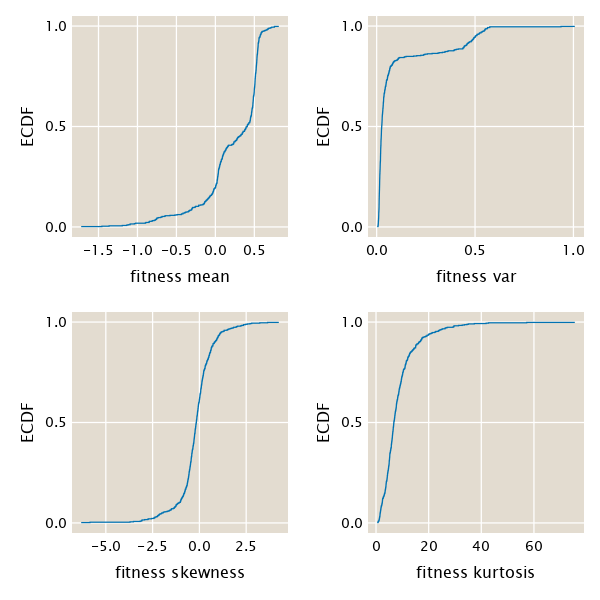

In [91]:
# Initialize figure
fig = Figure(resolution=(300 * 2, 300 * 2))

# Add axis
axes = [
    Axis(
        fig[i, j],
        ylabel="ECDF"
    ) for i = 1:2 for j = 1:2
]

# List quantities to plot
qs = ["mean", "var", "skewness", "kurtosis"]

# Loop through quantities
for (i, q) in enumerate(qs)
    # Plot quantity
    ecdfplot!(axes[i], df_summary[:, "value_"*q])
    # Add title
    axes[i].xlabel = "fitness $(q)"
end # for

fig

Focusing in particular on the skewness⸺which we expect to be zero for a
symmetric distribution⸺the vast majority of the density concentrates around
zero, but there are some extreme values. Let's look at a couple of distributions
with extreme skewness values.

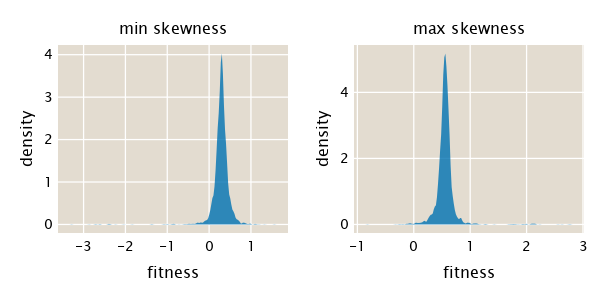

In [92]:
# Identify minimum and maximum value of skewness
min_skew, max_skew = [
    df_summary[argmin(df_summary.value_skewness), :variable]
    df_summary[argmax(df_summary.value_skewness), :variable]
]

# Initialize plot
fig = Figure(resolution=(300 * 2, 300))

# Add axis
axes = [
    Axis(
        fig[1, i],
        xlabel="fitness",
        ylabel="density"
    ) for i = 1:2
]

# Define plot titles 
titles = ["min skewness", "max skewness"]

# loop through barcodes
for (i, bc) in enumerate([min_skew, max_skew])
    # plot density for fitness value
    density!(axes[i], df[df.variable.==bc, :value])
    # Add title
    axes[i].title = titles[i]
end # for

fig

We can see that even the distributions with extreme skewness values are fairly
symmetric. The high skewness must come from the few outliers in the samples.
Let's repeat the same plot, this time only including the 95% highest density
percentile.

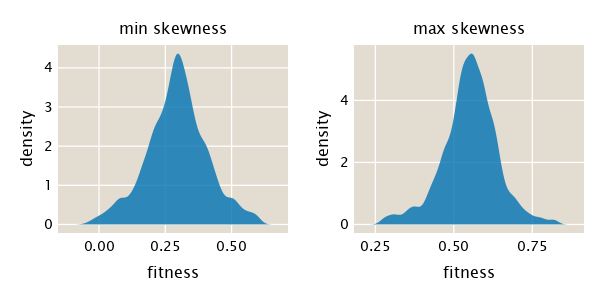

In [93]:
# Identify minimum and maximum value of skewness
min_skew, max_skew = [
    df_summary[argmin(df_summary.value_skewness), :variable]
    df_summary[argmax(df_summary.value_skewness), :variable]
]

# Initialize plot
fig = Figure(resolution=(300 * 2, 300))

# Add axis
axes = [
    Axis(
        fig[1, i],
        xlabel="fitness",
        ylabel="density"
    ) for i = 1:2
]

# Define plot titles 
titles = ["min skewness", "max skewness"]

# loop through barcodes
for (i, bc) in enumerate([min_skew, max_skew])
    # Extract values
    skew = df[df.variable.==bc, :value]
    # Keep only selected percentile
    skew = skew[
        (skew.≥StatsBase.percentile(skew, 2.5)).&(skew.≤StatsBase.percentile(skew, 97.5))
    ]
    # plot density for fitness value
    density!(axes[i], skew)
    # Add title
    axes[i].title = titles[i]
end # for

fig

Removing the extreme values does return a reasonably symmetric distribution.
Let's compute the summary statistics only using the 95% percentile.

In [94]:
# Group data by barcode
df_group = DF.groupby(df, :variable)

# Initialize dataframe to save summaries
df_filt = DF.DataFrame()

# Loop through groups
for g in df_group
    # Filter data
    DF.append!(
        df_filt,
        g[(g.value.≥StatsBase.percentile(g.value, 5)).&(g.value.≤StatsBase.percentile(g.value, 95)),
            :]
    )
end # group

# Compute skewness and kurtosis
df_filt_summary = DF.combine(
    DF.groupby(df_filt, :variable),
    :value => StatsBase.median,
    :value => StatsBase.mean,
    :value => StatsBase.std,
    :value => StatsBase.var,
    :value => StatsBase.skewness,
    :value => StatsBase.kurtosis
)

first(df_filt_summary, 5)

Row,variable,value_median,value_mean,value_std,value_var,value_skewness,value_kurtosis
,String,Float64,Float64,Float64,Float64,Float64,Float64
1,s[53],0.513522,0.510899,0.0485451,0.00235663,-0.167573,-0.342574
2,s[151],0.254047,0.258223,0.0790258,0.00624508,0.127708,-0.47385
3,s[262],0.557161,0.558127,0.0611749,0.00374237,0.097629,-0.172319
4,s[273],0.422621,0.42902,0.0931371,0.00867451,0.405562,0.212425
5,s[323],0.416368,0.412624,0.111286,0.0123846,0.00909269,-0.328539


As before, Let's plot the distribution of these summary statistics.

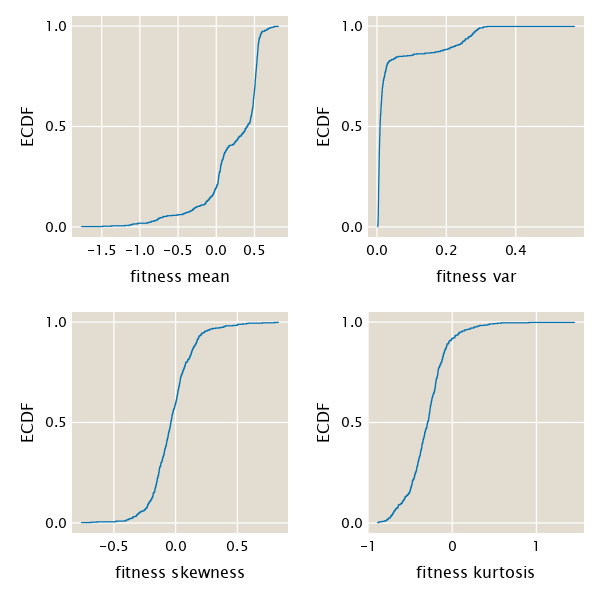

In [95]:
# Initialize figure
fig = Figure(resolution=(300 * 2, 300 * 2))

# Add axis
axes = [
    Axis(
        fig[i, j],
        ylabel="ECDF"
    ) for i = 1:2 for j = 1:2
]

# List quantities to plot
qs = ["mean", "var", "skewness", "kurtosis"]

# Loop through quantities
for (i, q) in enumerate(qs)
    # Plot quantity
    ecdfplot!(axes[i], df_filt_summary[:, "value_"*q])
    # Add title
    axes[i].xlabel = "fitness $(q)"
end # for

fig

Focusing again on the skewness, we still find some values that deviate from the
expected zero-value for symmetric distributions. Let's plot the probability
density for the fitness value of these extreme values.

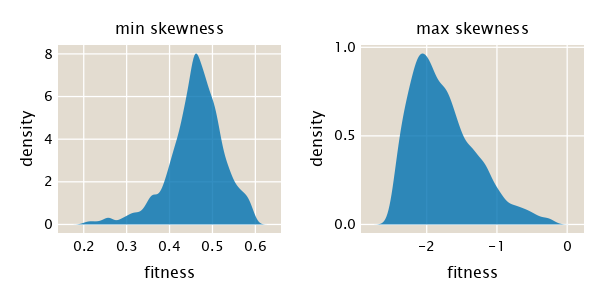

In [96]:
# Identify minimum and maximum value of skewness
min_skew, max_skew = [
    df_filt_summary[argmin(df_filt_summary.value_skewness), :variable]
    df_filt_summary[argmax(df_filt_summary.value_skewness), :variable]
]

# Initialize plot
fig = Figure(resolution=(300 * 2, 300))

# Add axis
axes = [
    Axis(
        fig[1, i],
        xlabel="fitness",
        ylabel="density"
    ) for i = 1:2
]

# Define plot titles 
titles = ["min skewness", "max skewness"]

# loop through barcodes
for (i, bc) in enumerate([min_skew, max_skew])
    # plot density for fitness value
    density!(axes[i], df_filt[df_filt.variable.==bc, :value])
    # Add title
    axes[i].title = titles[i]
end # for

fig

These are indeed not symmetric. But notice the range of the density plots; these
extreme skewness values com from poorly identified fitness values. The
distribution of variance values above reveals a set of identified and poorly
identified fitness values. Let's plot this distribution to emphasize the point.

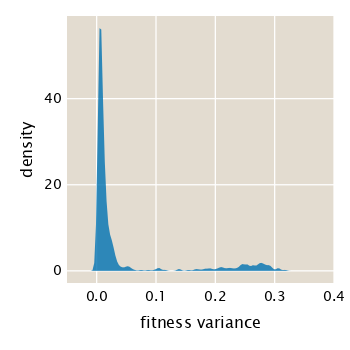

In [97]:
# Initialize figure
fig = Figure(resolution=(350, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="fitness variance",
    ylabel="density",
)

# Plot density
density!(ax, df_filt_summary[:, :value_var])

# Set x-axis range
xlims!(ax, [-0.05, 0.4])

fig

Most of the barcode inferences have a variance $\leq$ to 0.1. Let us filter out
everything above this value and look at the skewness distribution.

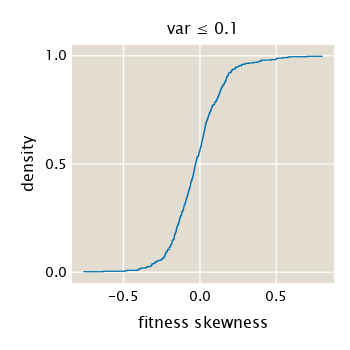

In [98]:
# Initialize figure
fig = Figure(resolution=(350, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="fitness skewness",
    ylabel="density",
    title="var ≤ 0.1"
)

# Plot density
ecdfplot!(
    ax, df_filt_summary[df_filt_summary.value_var.≤0.1, :value_skewness]
)

fig

As expected, removing the high-variance estimates reduces the range of skewness
values. Let's look at the extreme distributions for these further-filtered
barcodes.

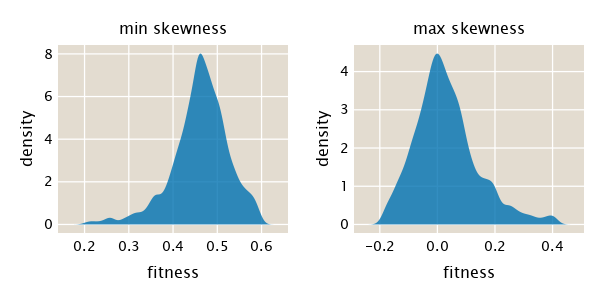

In [99]:
# Filter barcodes by variance
df_filt_summary_var = df_filt_summary[df_filt_summary.value_var.≤0.1, :]

# Identify minimum and maximum value of skewness
min_skew, max_skew = [
    df_filt_summary_var[argmin(df_filt_summary_var.value_skewness), :variable]
    df_filt_summary_var[argmax(df_filt_summary_var.value_skewness), :variable]
]

# Initialize plot
fig = Figure(resolution=(300 * 2, 300))

# Add axis
axes = [
    Axis(
        fig[1, i],
        xlabel="fitness",
        ylabel="density"
    ) for i = 1:2
]

# Define plot titles 
titles = ["min skewness", "max skewness"]

# loop through barcodes
for (i, bc) in enumerate([min_skew, max_skew])
    # plot density for fitness value
    density!(axes[i], df_filt[df_filt.variable.==bc, :value])
    # Add title
    axes[i].title = titles[i]
end # for

fig

The distributions are indeed fairly symmetric when filtering out the
high-variance inferences.

## Systematic fitting of Gaussian distributions

Where does this analysis leave us? What we can safely conclude is that for the
vast majority of the barcodes, fitting a parametric Gaussian curve to the MCMC
chains is a good-enough approximation. This does not generalize to all cases,
but we might consider discarding the cases that fail anyways because they tend
to be poorly-determined fitness values.

Let's then systematically summarize all MCMC chains.

In [100]:
# Initialize dataframe to save fit values
df_fit = DF.DataFrame()

# Define percentiles to include
per = [2.5, 97.5, 16, 84]

# Loop through files
for f in chn_files
    ## EXTRACT METADATA ##
    # Split filename to extract metadata
    meta_str = split(split(f, "/")[end], "_")
    # Extract metadata
    env = replace(meta_str[2], "env" => "")
    rep = replace(meta_str[3], "rep" => "")
    rmT0 = parse(Bool, replace(meta_str[4], "rmT0.jld2" => ""))

    ## LOAD AND FORMAT CHAIN ##
    # Load chain and group object form .jld2 file
    chn, group = values(JLD2.load(f))

    # Search for variable names
    s_names = MCMCChains.namesingroup(chn, "s̲⁽ᵐ⁾")

    # Rename variables
    chn = MCMCChains.replacenames(
        chn, Dict(zip(s_names, ["s[$(x)]" for x in group]))
    )

    ## CONVERT TO TIDY DATAFRAME ##
    # Define variable fitness variable names
    var_names = MCMCChains.namesingroup(chn, "s")

    # Convert chain to tidy dataframe
    df = DF.stack(DF.DataFrame(chn[var_names]), DF.Not([:iteration, :chain]))

    ## FILTER 95% ##

    # Group data by barcode
    df_group = DF.groupby(df, :variable)

    # Initialize dataframe to save summaries
    df_filt = DF.DataFrame()

    # Loop through groups
    for g in df_group
        # Filter data
        DF.append!(
            df_filt,
            g[(g.value.≥StatsBase.percentile(g.value, 5)).&(g.value.≤StatsBase.percentile(g.value, 95)),
                :]
        )
    end # group

    # Compute summary statistics
    df_summary = DF.combine(
        DF.groupby(df_filt, :variable),
        :value => StatsBase.median,
        :value => StatsBase.mean,
        :value => StatsBase.std,
        :value => StatsBase.var,
        :value => StatsBase.skewness,
        :value => StatsBase.kurtosis,
    )

    # Loop through percentiles
    for p in per
        # Compute and add percentile
        DF.leftjoin!(
            df_summary,
            # Rename column from :value_function to :p_percentile
            DF.rename!(
                # Compute percentile p for each group
                DF.combine(
                    # Group MCMC chains by :variable, :value
                    DF.groupby(df_filt[:, [:variable, :value]], :variable),
                    # Define anonymous function to compute percentile
                    :value => x -> StatsBase.percentile(x, p)
                ),
                :value_function => Symbol("$(p)_percentile")
            );
            on=:variable
        )
    end # for


    # Add inference metadata
    DF.insertcols!(
        df_summary,
        :env .=> env,
        :rep .=> rep,
        :rmT0 .=> rmT0
    )

    # Append to dataframe
    DF.append!(df_fit, df_summary)
end # for

# Rename columns
DF.rename!(
    df_fit,
    :variable => :barcode,
    :value_median => :median,
    :value_mean => :mean,
    :value_std => :std,
    :value_var => :var,
    :value_skewness => :skewness,
    :value_kurtosis => :excess_kurtosis,
)

# Replace barcode name from "s[x]" to x
df_fit.barcode .= parse.(Int64, replace.(df_fit.barcode, "s[" => "", "]" => ""))

# Extract barcode metadata to be added
df_bc_meta = unique(data[:, [:barcode, :class, :gene, :ploidy, :type]])
# Add barcode metadata
DF.leftjoin!(df_fit, df_bc_meta; on=:barcode)

# Write dataframe to CSV file
CSV.write("$(git_root())/data/kinsler_2020/fitness_gaussian_fit.csv", df_fit)

first(df_fit, 10)

Row,barcode,median,mean,std,var,skewness,excess_kurtosis,2.5_percentile,97.5_percentile,16.0_percentile,84.0_percentile,env,rep,rmT0,class,gene,ploidy,type
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64?,Float64?,Float64?,Float64?,String,String,Bool,String31,String31,String15,String31
1,53,0.513522,0.510899,0.0485451,0.00235663,-0.167573,-0.342574,0.409864,0.602417,0.461338,0.560113,0.2MKCl,R1,false,Diploid,Diploid,Diploid,Diploid
2,151,0.254047,0.258223,0.0790258,0.00624508,0.127708,-0.47385,0.10966,0.413523,0.178852,0.341855,0.2MKCl,R1,false,PKA,IRA1,Haploid,stop_gained
3,262,0.557161,0.558127,0.0611749,0.00374237,0.097629,-0.172319,0.435613,0.684632,0.496895,0.617957,0.2MKCl,R1,false,NotSequenced,NotSequenced,NotSequenced,NotSequenced
4,273,0.422621,0.42902,0.0931371,0.00867451,0.405562,0.212425,0.260527,0.635921,0.337738,0.517377,0.2MKCl,R1,false,PKA,IRA1,Haploid,frameshift_variant
5,323,0.416368,0.412624,0.111286,0.0123846,0.00909269,-0.328539,0.193479,0.642537,0.297045,0.521699,0.2MKCl,R1,false,NotSequenced,NotSequenced,NotSequenced,NotSequenced
6,415,-0.345349,-0.349083,0.0969115,0.00939183,-0.147255,-0.125024,-0.557124,-0.159907,-0.444638,-0.253932,0.2MKCl,R1,false,PKA,IRA1,Haploid,frameshift_variant
7,499,0.0553692,0.0401917,0.496897,0.246907,-0.124045,-0.674182,-0.923055,0.923462,-0.482316,0.578651,0.2MKCl,R1,false,NotSequenced,NotSequenced,NotSequenced,NotSequenced
8,622,0.49289,0.495338,0.0725814,0.00526806,0.061171,-0.0835724,0.347784,0.648776,0.427969,0.566484,0.2MKCl,R1,false,NotSequenced,NotSequenced,NotSequenced,NotSequenced
9,689,-0.737336,-0.742366,0.111783,0.0124955,-0.201276,-0.120194,-0.983404,-0.526391,-0.852991,-0.634323,0.2MKCl,R1,false,PKA,IRA1,Haploid,frameshift_variant


### Exploring summary statistics

Let's look at some of the correlation between a few of the variables.

For example, we expect the mean and the median to be almost mirror-images of
each other. Let's plot one against the other.

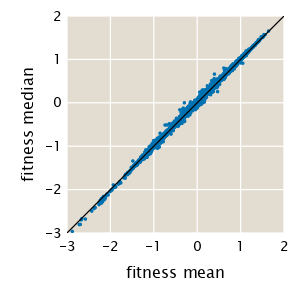

In [101]:
# Intialize figure
fig = Figure(resolution=(300, 300))

# Add axis
ax = Axis(fig[1, 1], xlabel="fitness mean", ylabel="fitness median")

# Plot mean vs median
scatter!(ax, df_fit.mean, df_fit.median, markersize=5)

# Plot identity line
lines!(ax, [-4, 4], [-4, 4], color=:black)

# Seet axis limits
xlims!(ax, [-3, 2])
ylims!(ax, [-3, 2])

fig

These are as correlated as I expected.

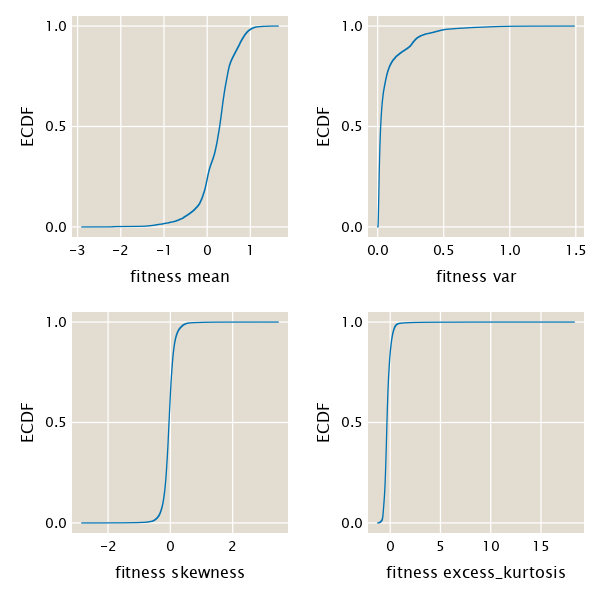

In [102]:
# Initialize figure
fig = Figure(resolution=(300 * 2, 300 * 2))

# Add axis
axes = [
    Axis(
        fig[i, j],
        ylabel="ECDF"
    ) for i = 1:2 for j = 1:2
]

# List quantities to plot
qs = ["mean", "var", "skewness", "excess_kurtosis"]

# Loop through quantities
for (i, q) in enumerate(qs)
    # Plot quantity
    ecdfplot!(axes[i], df_fit[:, q])
    # Add title
    axes[i].xlabel = "fitness $(q)"
end # for

fig

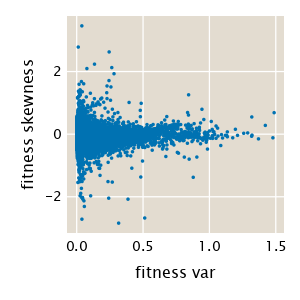

In [103]:
# Intialize figure
fig = Figure(resolution=(300, 300))

# Add axis
ax = Axis(fig[1, 1], xlabel="fitness var", ylabel="fitness skewness")

# Plot mean vs median
scatter!(ax, df_fit.var, df_fit.skewness, markersize=5)

fig

### Replicate-to-replicate variability

Let's take a look at the replicate-to-replicate variability. First, let's plot 
the pairwise comparison

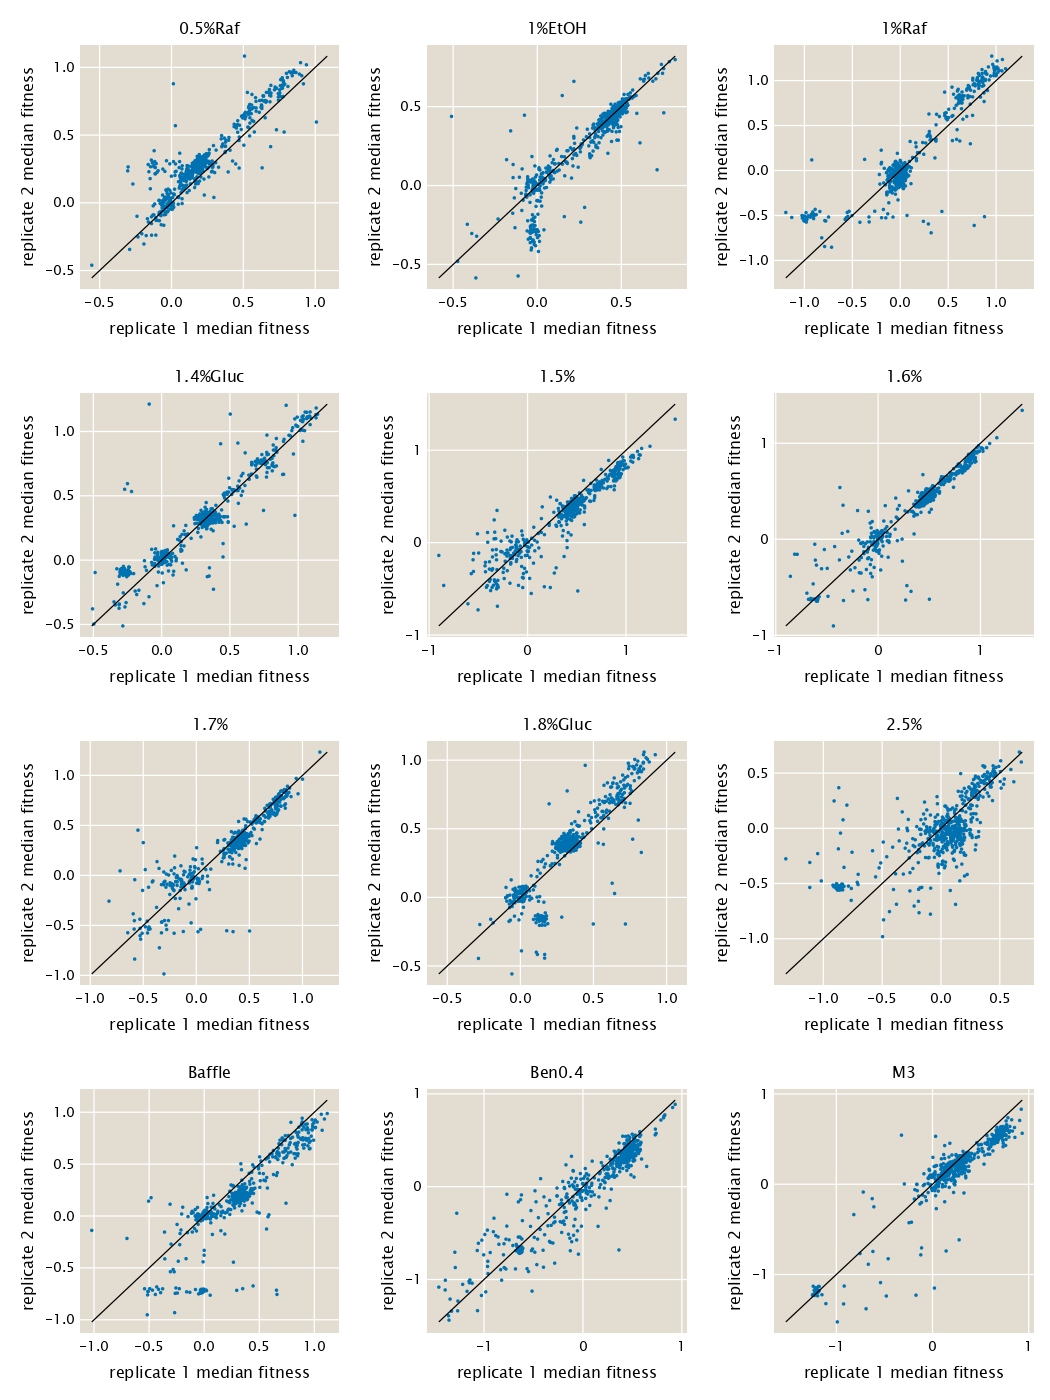

In [104]:
# Group data by environment
df_group = DF.groupby(df_fit, :env)

# Find environments with two repeats
reps = [length(unique(g.rep)) for g in df_group] .≥ 2

# Keep groups with two repeats
df_group = df_group[reps]

# Define number of rows and columns
n_row, n_col = [4, 3]

# Initialize figure
fig = Figure(resolution=(350 * n_col, 350 * n_row))

# Add GridLayout
gl = fig[1, 1] = GridLayout()

# Add axis
axes = [
    Axis(
        gl[i, j],
        xlabel="replicate 1 median fitness",
        ylabel="replicate 2 median fitness",
    ) for i = 1:n_row for j = 1:n_col
]

# Loop through groups
for (i, data) in enumerate(df_group)
    # Unstack dataframe to plot columns
    d = DF.unstack(data[:, [:barcode, :rep, :median]], :rep, :median)

    # Plot Rep 1 vs Rep 2
    if first(data.env) == "M3"
        # Extract repeats to be used for M3
        m3 = [d.R6, d.R7]
        # Plot R1 vs R2
        scatter!(axes[i], m3..., markersize=5)
        # Plot identity line
        lines!(
            axes[i],
            repeat([[minimum(vcat(m3...)), maximum(vcat(m3...))]], 2)...;
            color=:black
        )
    else
        # Plot R1 vs R2
        scatter!(axes[i], d.R1, d.R2, markersize=5)
        # Plot identity line
        lines!(
            axes[i],
            repeat([[minimum(data.median), maximum(data.median)]], 2)...;
            color=:black
        )
    end # if

    # Add title
    axes[i].title = first(data.env)

end # for

fig

Let's now add errorbars to this plot. The error bars will represent the 68
percentile.

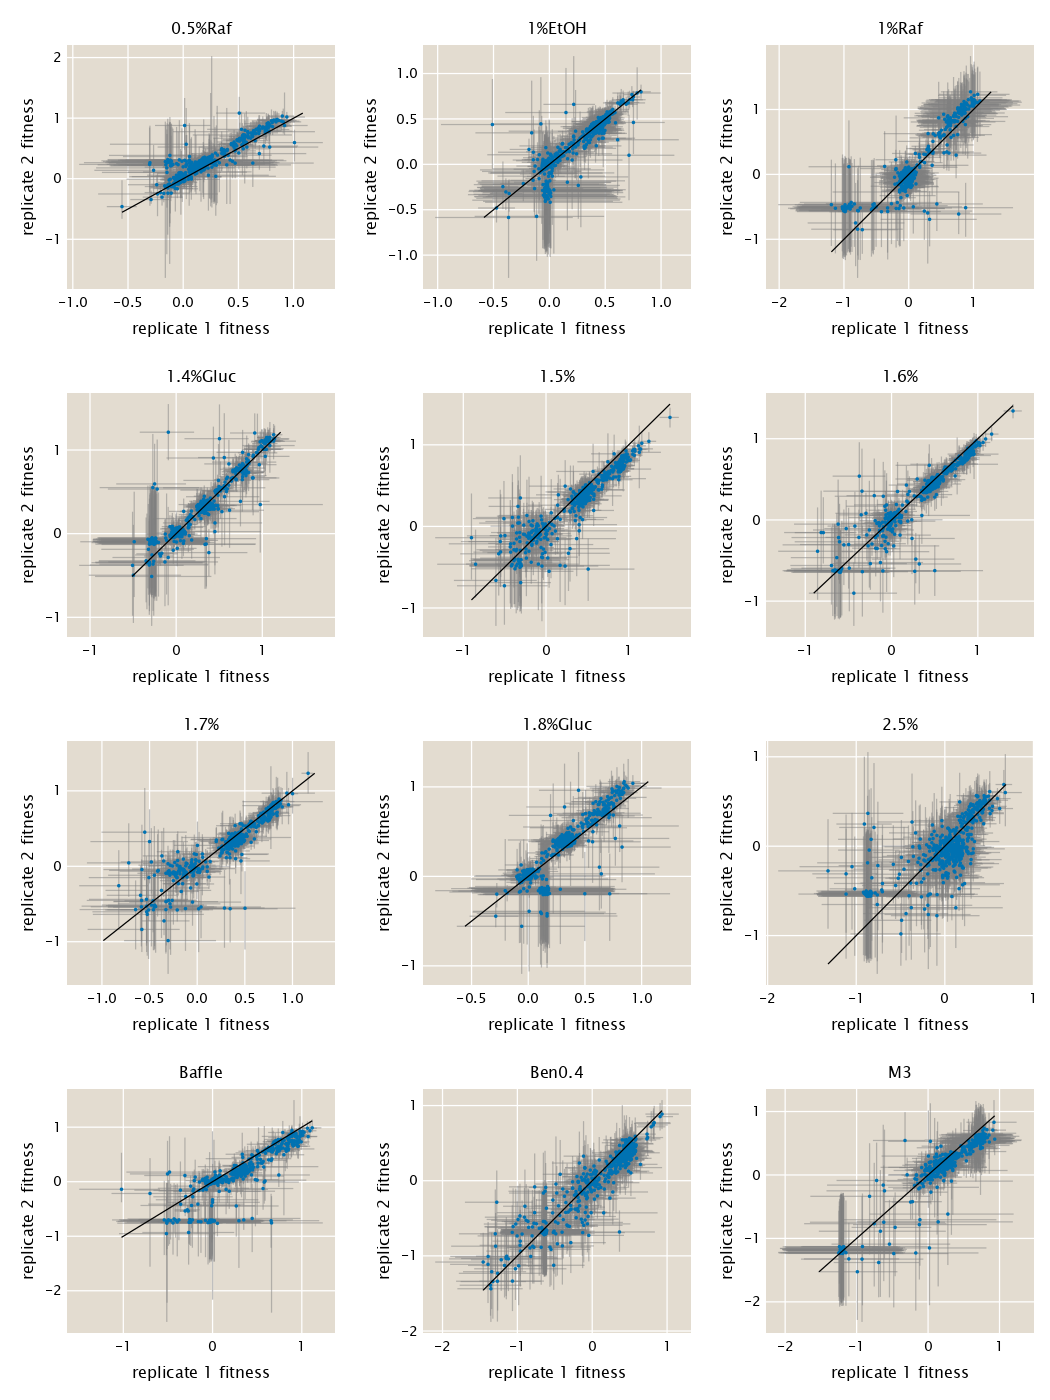

In [105]:
# Group data by environment
df_group = DF.groupby(df_fit, :env)

# Find environments with two repeats
reps = [length(unique(g.rep)) for g in df_group] .≥ 2

# Keep groups with two repeats
df_group = df_group[reps]

# Define number of rows and columns
n_row, n_col = [4, 3]

# Initialize figure
fig = Figure(resolution=(350 * n_col, 350 * n_row))

# Add GridLayout
gl = fig[1, 1] = GridLayout()

# Add axis
axes = [
    Axis(
        gl[i, j],
        xlabel="replicate 1 fitness",
        ylabel="replicate 2 fitness",
    ) for i = 1:n_row for j = 1:n_col
]

# Loop through groups
for (i, data) in enumerate(df_group)
    # Unstack dataframe to plot columns (median)
    d = DF.sort(
        DF.unstack(data[:, [:barcode, :rep, :median]], :rep, :median),
        [:barcode]
    )

    # Unstack dataframe to plot columns (16 percentile)
    d_low = DF.sort(
        DF.unstack(
            data[:, [:barcode, :rep, Symbol("16.0_percentile")]],
            :rep,
            Symbol("16.0_percentile")
        ),
        [:barcode]
    )
    # Unstack dataframe to plot columns (84 percentile)
    d_high = DF.sort(
        DF.unstack(
            data[:, [:barcode, :rep, Symbol("84.0_percentile")]],
            :rep,
            Symbol("84.0_percentile")
        ),
        [:barcode]
    )


    # Plot Rep 1 vs Rep 2
    if first(data.env) == "M3"
        # Extract repeats to be used for M3
        m3 = [d.R6, d.R7]
        m3_low = [d_low.R6, d_low.R7]
        m3_high = [d_high.R6, d_high.R7]
        # Add y-axis error bars
        errorbars!(
            axes[i],
            m3[1],
            m3[2],
            abs.(m3[1] .- m3_low[1]),
            abs.(m3[1] .- m3_high[1]),
            color=(:gray, 0.5)
        )

        # Add x-axis error bars
        errorbars!(
            axes[i],
            m3[1],
            m3[2],
            abs.(m3[2] .- m3_low[2]),
            abs.(m3[2] .- m3_high[2]),
            color=(:gray, 0.5),
            direction=:x
        )
        # Plot R1 vs R2
        scatter!(axes[i], m3..., markersize=5)
        # Plot identity line
        lines!(
            axes[i],
            repeat([[minimum(vcat(m3...)), maximum(vcat(m3...))]], 2)...;
            color=:black
        )
    else
        # Add y-axis error bars
        errorbars!(
            axes[i],
            d.R1,
            d.R2,
            abs.(d.R1 .- d_low.R1),
            abs.(d.R1 .- d_high.R1),
            color=(:gray, 0.5)
        )

        # Add x-axis error bars
        errorbars!(
            axes[i],
            d.R1,
            d.R2,
            abs.(d.R2 .- d_low.R2),
            abs.(d.R2 .- d_high.R2),
            color=(:gray, 0.5),
            direction=:x
        )

        # Plot R1 vs R2
        scatter!(axes[i], d.R1, d.R2, markersize=5)

        # Plot identity line
        lines!(
            axes[i],
            repeat([[minimum(data.median), maximum(data.median)]], 2)...;
            color=:black
        )
    end # if

    # Add title
    axes[i].title = first(data.env)

end # for

fig

## Comparison with previous inference method

An important comparison to be made is with the previous inference method. Let's
load the previous fitness measurements.

In [106]:
# Load previous-method fitness inferences
df_prev = CSV.read(
    "$(git_root())/data/kinsler_2020/tidy_fitness_mle.csv", DF.DataFrame
)

# Initialize array where to save rep number. NOTE: This is done to split the 
# `EC Batch #`
rep = ones(Int64, size(df_prev, 1))

# Extract unique `EC Batch #` environments
ec_env = unique(df_prev.environment[occursin.("EC Batch", df_prev.environment)])

# Loop through EC envs
for env in ec_env
    # Extract and save replicate number
    rep[df_prev.environment.==env] .= parse(Int64, split(env, " ")[end])
    # Modify environment to be `EC Batch` only
    df_prev[df_prev.environment.==env, :environment] .= "EC Batch"
end # for

# Add rep column
df_prev[!, :rep] = ["R$(r)" for r in rep]

first(df_prev[:, DF.Not(:additional_muts)], 3)

Row,barcode,gene,type,ploidy,class,mutation_type,environment,fitness,error,rep
,Int64,String31,String31,String15,String31,String31,String31,Float64,Float64,String
1,53,Diploid,Diploid,Diploid,Diploid,Diploid,EC Batch,0.28972,0.0312521,R19
2,53,Diploid,Diploid,Diploid,Diploid,Diploid,EC Batch,0.323919,0.0452421,R3
3,53,Diploid,Diploid,Diploid,Diploid,Diploid,EC Batch,0.165198,0.0751646,R6


This dataframe uses a different naming convention for the environments. The file
`env_equivalence.csv` is a manually-curated mapping between (most) environment
names. Let's map these names to the new environments

In [107]:
# Read environment naming convention
df_env = CSV.read(
    "$(git_root())/data/kinsler_2020/env_equivalence.csv", DF.DataFrame
)

# Drop environemnts that have a missing entry
DF.dropmissing!(df_env)

# Initialize array to save new environment name
# envs = Array{Union{String,Missing}}(missing, size(df_prev, 1))
envs = repeat(["None"], size(df_prev, 1))

# Loop through old environments
for row in eachrow(df_env)
    # Add corresponding environment
    envs[df_prev.environment.==row.old] .= row.new
end # for

# Add column to dataframe
df_prev[!, :env] = envs

first(df_prev[:, DF.Not(:additional_muts)], 3)

Row,barcode,gene,type,ploidy,class,mutation_type,environment,fitness,error,rep,env
,Int64,String31,String31,String15,String31,String31,String31,Float64,Float64,String,String
1,53,Diploid,Diploid,Diploid,Diploid,Diploid,EC Batch,0.28972,0.0312521,R19,M3
2,53,Diploid,Diploid,Diploid,Diploid,Diploid,EC Batch,0.323919,0.0452421,R3,M3
3,53,Diploid,Diploid,Diploid,Diploid,Diploid,EC Batch,0.165198,0.0751646,R6,M3


To plot the comparison, we must find the environment/replicate pairs that appear
in both datasets as well as the common barcodes.

In [108]:
# Collect groups for previous inference
keys_prev = values.(keys(DF.groupby(df_prev, [:env, :rep])))

# Collect groups for new inference 
keys_fit = values.(keys(DF.groupby(df_fit, [:env, :rep])))

# Find intersecting groups
keys_intersect = intersect(keys_prev, keys_fit)

# Find intersecting barcodes
bc_intersect = intersect(unique(df_fit.barcode), unique(df_prev.barcode))

println("# envs = $(length(keys_intersect))")
println("# barcodes = $(length(bc_intersect)) out of $(length(unique(df_fit.barcode)))")


# envs = 18
# barcodes = 418 out of 536


We see that a little over 100 barcodes were excluded from the original Kinsler
et al dataset. The authors did not explain why this is the case, so I'll need to
ask them directly.

Let's now plot the pairwise comparisons.

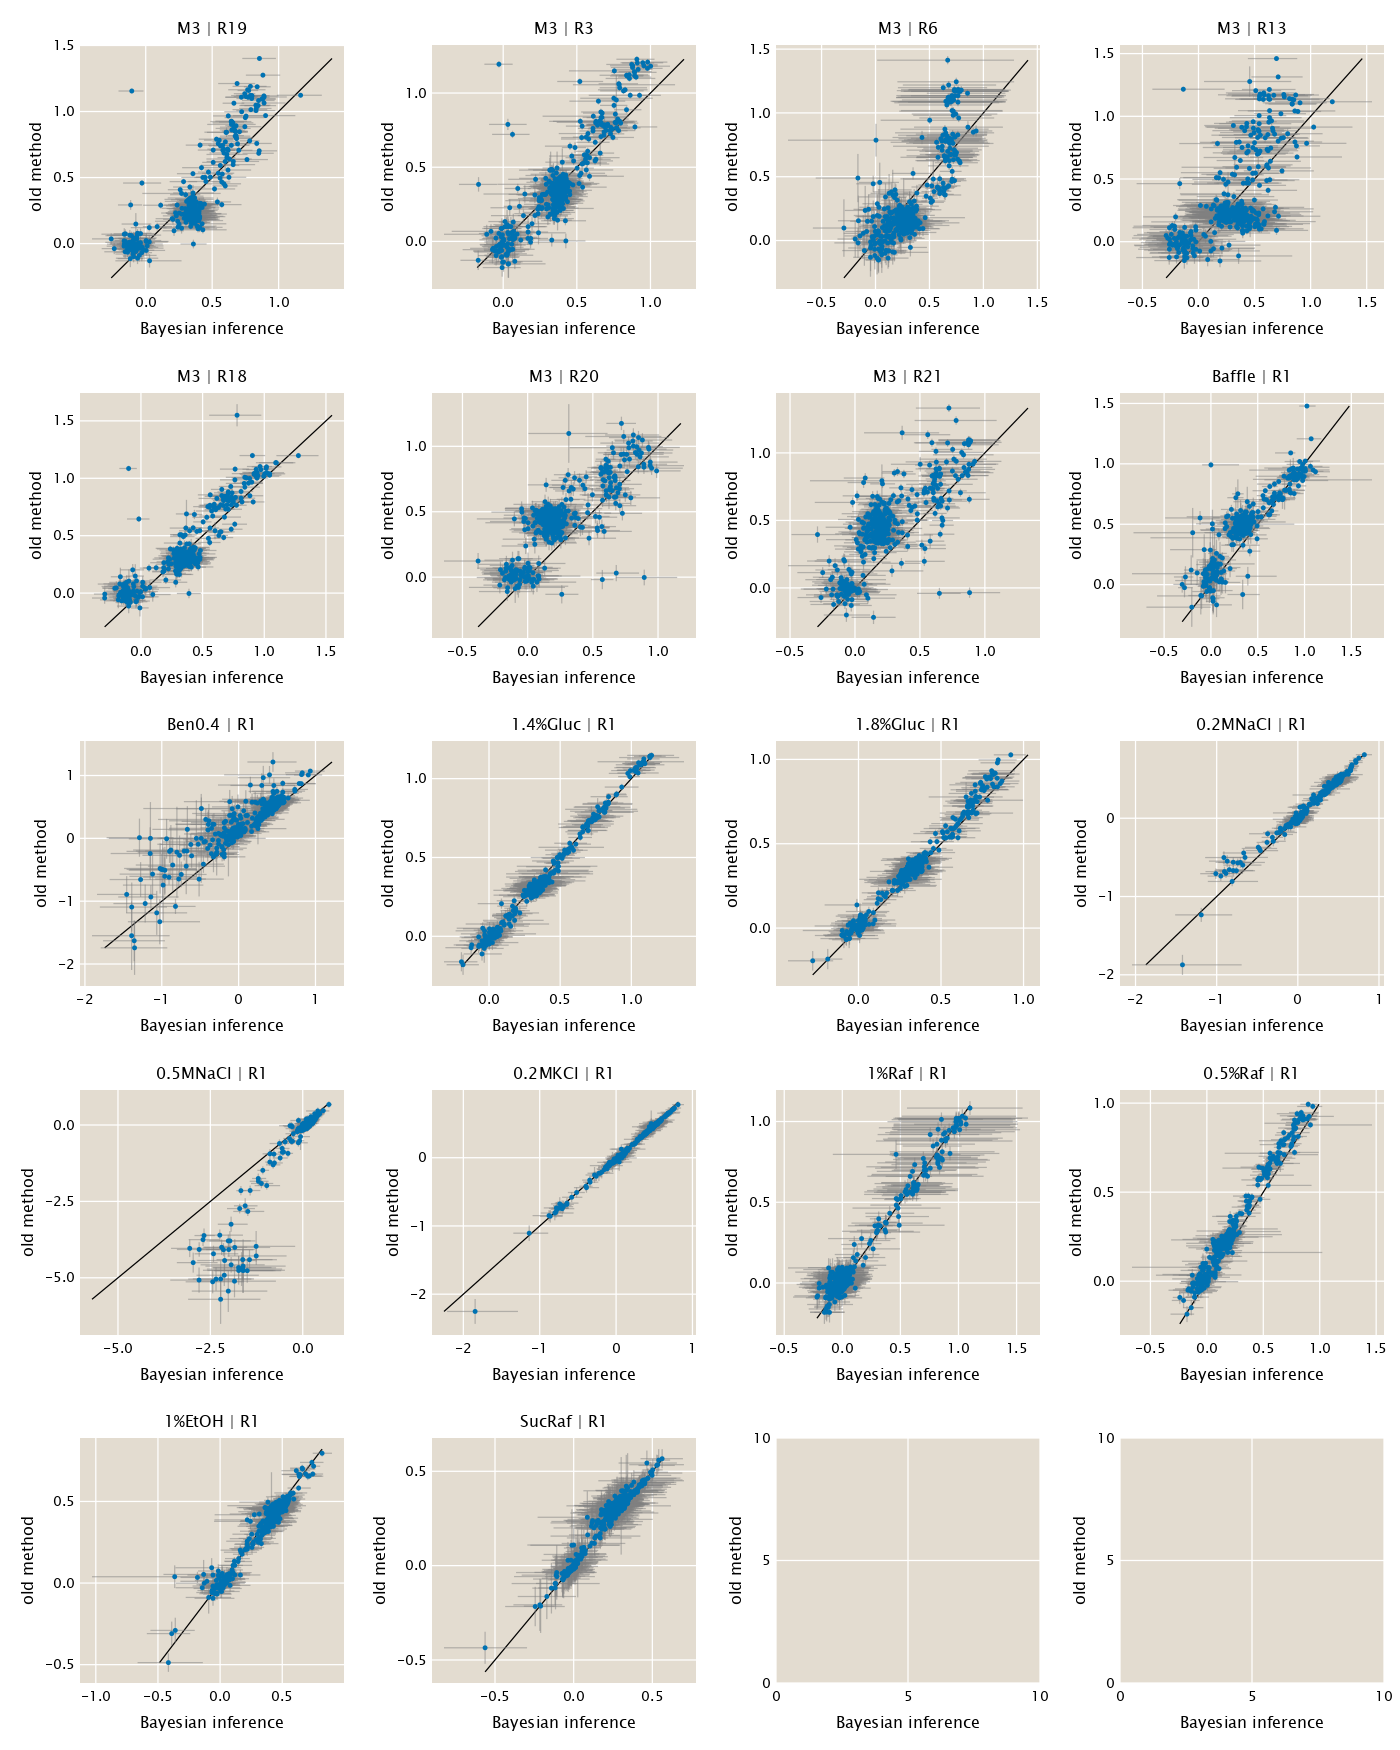

In [109]:

# Define number of rows and columns in subplots
n_col, n_row = [4, 5]

# Initialize figure
fig = Figure(resolution=(350 * n_col, 350 * n_row))

# Add GridLayout
gl = fig[1, 1] = GridLayout()

# Add axis
axes = [
    Axis(
        gl[i, j],
        xlabel="Bayesian inference",
        ylabel="old method",
    ) for i = 1:n_row for j = 1:n_col
]

# Loop through groups
for (i, (env, rep)) in enumerate(keys_intersect)
    # Extract old and new inference
    data_bayes = DF.sort!(
        df_fit[
            (df_fit.env.==env).&(df_fit.rep.==rep).&([x ∈ bc_intersect for x in df_fit.barcode]),
            :],
        :barcode
    )
    data_prev = DF.sort!(
        df_prev[
            (df_prev.env.==env).&(df_prev.rep.==rep).&([x ∈ bc_intersect for x in df_prev.barcode]),
            :],
        :barcode
    )

    # Plot identity line
    lines!(
        axes[i],
        repeat([[
                minimum([data_bayes.median; data_prev.fitness]),
                maximum([data_bayes.median; data_prev.fitness])
            ]],
            2)...,
        color=:black
    )

    # Plot x-axis error-bar
    errorbars!(
        axes[i],
        data_bayes.median,
        data_prev.fitness,
        abs.(data_bayes.median .- data_bayes[:, Symbol("16.0_percentile")]),
        abs.(data_bayes.median .- data_bayes[:, Symbol("84.0_percentile")]),
        color=(:gray, 0.5),
        direction=:x
    )

    # Plot y-axis error-bar
    errorbars!(
        axes[i],
        data_bayes.median,
        data_prev.fitness,
        data_prev.error,
        color=(:gray, 0.5),
        direction=:y
    )

    # Plot centroid
    scatter!(axes[i], data_bayes.median, data_prev.fitness, markersize=7)

    # Set title
    axes[i].title = "$(env) | $(rep)"
end # for

fig

Although there are some suspiciously-diverging comparisons, these are mostly for
the M3 datasets, where I am less certain about the replicate number matching
with each other (something interesting to consider about the M3 data), the rest
of the comparisons look really good. As expected, the error bars from the
Bayesian inference look significantly bigger than with the older method.